# Import

In [1]:
# Клонируем репозитерий stylegan2-ada-pytorch
!git clone https://github.com/NVlabs/stylegan2-ada-pytorch.git /content/stylegan2-ada-pytorch

Cloning into '/content/stylegan2-ada-pytorch'...
remote: Enumerating objects: 131, done.
remote: Counting objects: 100% (2/2), done.
remote: Compressing objects: 100% (2/2), done.
remote: Total 131 (delta 0), reused 0 (delta 0), pack-reused 129 (from 2)
Receiving objects: 100% (131/131), 1.13 MiB | 23.15 MiB/s, done.
Resolving deltas: 100% (57/57), done.


In [2]:
# Скачиваем модель StyleGAN2
!mkdir -p /content/StyleGAN2
!wget -q https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl -O /content/StyleGAN2/ffhq.pkl # модель обученная на датасете ffhq(лица)

In [3]:
!pip install -q git+https://github.com/openai/CLIP.git # установка CLIP
!pip install -q ninja # утилита для сборки C++/CUDA кода
!pip install -q youtokentome # библиотека от Яндекса для работы с BPE-токенизатором

  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.8/44.8 kB 3.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 180.7/180.7 kB 9.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 86.7/86.7 kB 6.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done


In [4]:
import sys
import os
sys.path.append('/content/stylegan2-ada-pytorch')
os.environ['TORCH_CUDA_ARCH_LIST'] = '7.5'

import pickle

import numpy as np

import clip

import torch
import torch.nn.functional as F
from torchvision.utils import make_grid

from PIL import Image
import matplotlib.pyplot as plt

import re

import warnings
warnings.filterwarnings('ignore')

RAND = 42

In [5]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Utils

In [ ]:
def cleaned_text(text) -> str:
    """Простая очистка текста"""
    text = str(text) if text is not None else '' # преобразование text в строку, если это не строка
    text = text.lower()
    text = re.sub(r'[^а-яёa-z0-9\s.,*!?:-]', '', text)  # удаление лишних символов (кроме пунктуации)
    text = re.sub(r'\s+', ' ', text).strip()  # удаление лишних пробелов
    text = re.sub(r'^[^\w]+', '', text)  # удаление пунктуации в начале строки
    text = text.strip(' .')  # убирает лишние пробелы и точки в начале и в конце строки
    return text

In [ ]:
def preprocessing_text(text: str,
                       device) -> torch.Tensor:
  """
  Делает простую очистку текста, токенизирует и возвращает эмбеддинги
  """
  model.eval()
  with torch.no_grad():
    text = cleaned_text(text)
    text_tokenize = clip.tokenize(text).to(device)
    text_features = model.encode_text(text_tokenize)

  return text_features

In [ ]:
def preprocessing_image(image,
                        device) -> torch.Tensor:
    """
    Если torch.Tensor, то преобразует его в PIL, делает препроцессинг
    и возвращает эмбеддинги изображения
    """

    model.eval()
    with torch.no_grad():
      if isinstance(image, torch.Tensor):
        # Для torch.Tensor из StyleGAN2 с диапазоном [-1,1]
        image = ((image + 1) / 2).clamp(0, 1) # [-1, 1] → [0, 1]
        image = (image * 255).to(torch.uint8) # конвертируем в диапазон [0, 255] и в тип uint8
        image = image.permute(1, 2, 0).cpu().numpy() # меняем формат с CHW → HWC и преобразуем в np.array
        image = Image.fromarray(image) # cоздаём PIL.Image
        image_preproc = preprocess(image).unsqueeze(0).to(device)
      else:
        # Для PIL-изображений
        image_preproc = preprocess(image).unsqueeze(0).to(device)

      # Визуализация изображения
      plt.figure(figsize=(8, 8))
      plt.imshow(image)
      plt.axis('off')
      plt.show()

      image_features = model.encode_image(image_preproc)

    return image_features

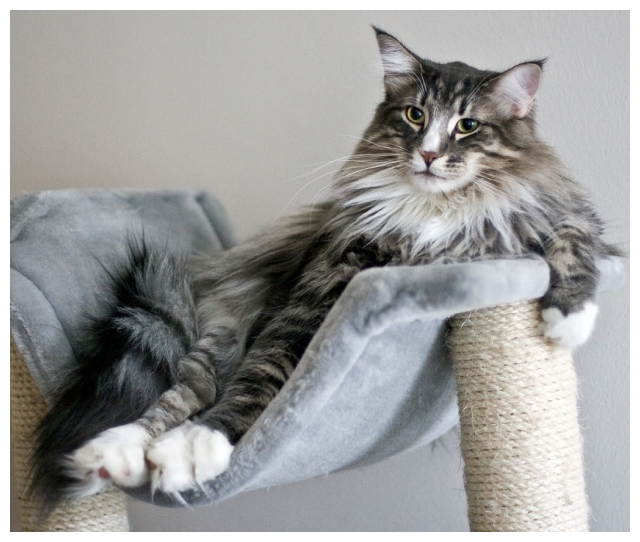

In [ ]:
# Загружаем свое фото
image =Image.open('/content/kot.jpg')

plt.figure(figsize=(8,8))
plt.imshow(image)
plt.axis('off')
plt.show()

# StyleGN2-ADA

In [8]:
with open('/content/StyleGAN2/ffhq.pkl', 'rb') as f:
  G = pickle.load(f)['G_ema'].to(device)

In [9]:
g = torch.Generator()
g.manual_seed(RAND)

z = torch.randn(4, G.z_dim, generator=g).to(device)
c = None
G.eval()
image_gan = G(z, c)

Setting up PyTorch plugin "bias_act_plugin"... Done.
Setting up PyTorch plugin "upfirdn2d_plugin"... Done.


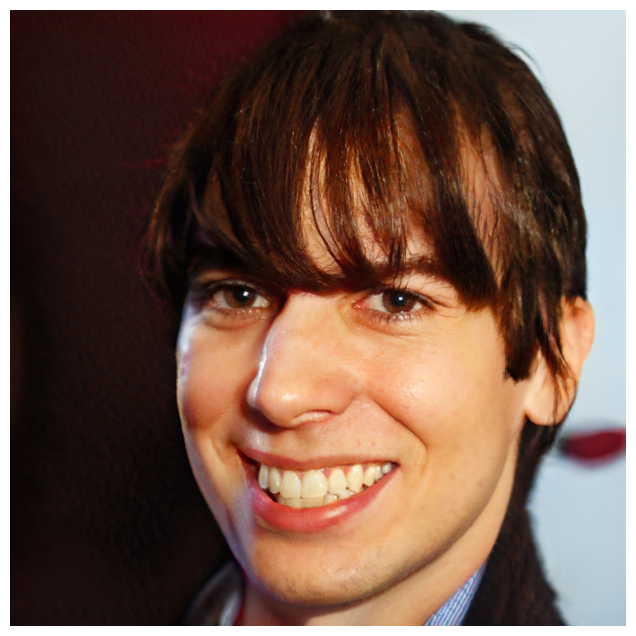

In [10]:
img = (image_gan[1].clamp(-1, 1) + 1) / 2.0  # [-1, 1] → [0, 1]
grid = make_grid(img, nrow=2)
plt.figure(figsize=(8, 8))
plt.imshow(grid.permute(1, 2, 0).detach().cpu().numpy())
plt.axis('off')
plt.show()

# CLIP

In [ ]:
# Загружаем модель и процессор
model, preprocess = clip.load('ViT-B/32', device=device)

100%|████████████████████████████████████████| 338M/338M [00:03<00:00, 102MiB/s]


In [ ]:
text_features = preprocessing_text('woman', device)

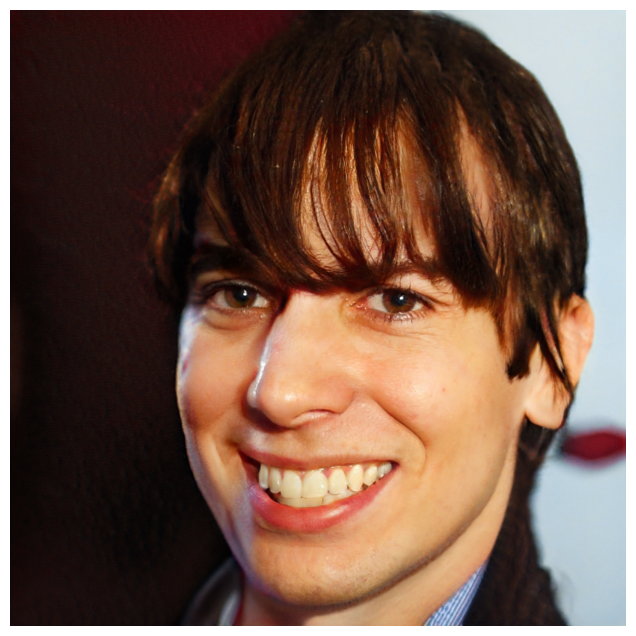

In [ ]:
image_features = preprocessing_image(image_gan[1], device)

# Metrics

In [ ]:
cos_sim = F.cosine_similarity(text_features, image_features, dim=1)
cos_sim

tensor([0.2053], device='cuda:0', dtype=torch.float16)

# Train

## Loss

In [ ]:
# Cosine distance
loss_clip = 1 - F.cosine_similarity(text_features, image_features, dim=1)

## Train

In [24]:
def freeze_generator(generator):
  """
  Замораживает веса модели
  """
  for param in G.named_parameters():



SyntaxError: incomplete input (ipython-input-2306322619.py, line 6)

In [ ]:
def traun(generator, data, optimizer):
  """
  Обучает генератор StyleGAN2
  """
  generator_freeze = generator.